In [42]:
import numpy as np
import torch 
import torch.nn as nn
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

In [43]:
def lirinzel_ns(v2, a2, IP3=0.5, d5=0.09, k3=0.08, dt=0.01):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 100, dt)
    dt = dt
    Ca, h = [0.1], [0.1]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

v2 = 0.1
a2 = 0.15
IP3 = 0.5
d5 = 0.09
k3  = 0.08

dt1 = 0.01
t1 = np.arange(0, 100, dt1)
Ca_euler1, h_euler1 = lirinzel_ns(v2, a2, IP3, d5, k3, dt1)

In [44]:

class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        mean = 0.0
        std = 0.1
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled


In [ ]:
Ca_euler = torch.tensor(Ca_euler1, dtype=torch.float32)[::100]
h_euler = torch.tensor(h_euler1, dtype=torch.float32)[::100]

torch.manual_seed(2)
pinn = PinnModel(hidden_units=30, num_features=3, y0=torch.tensor([0.1, 0.1]).view(1,-1))

t_test = torch.arange(0, 100, 0.01).view(-1, 1)
time = torch.arange(0, 100, 1.0).view(-1, 1)
t_initial = torch.tensor(0.0, requires_grad=True).view(-1, 1)
t_physics = torch.linspace(0, 100, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
IP3 = 0.5
d5 = 0.09
k3  = 0.08
pinf = IP3 / (IP3 + d1)
Q2 = d2 * (IP3 + d1) / (IP3 + d3)
v2_true = 0.1
a2_true = 0.15

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
lam1, lam2, lam3 = 1e-2, 1, 1e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2], lr=0.001)
epochs =  5001
v2s = []
a2s = []
Ca_predict = []
Ca_euler_pred = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    h_preds = sol[:, 1].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_euler)**2)
    loss2 = torch.mean((h_preds.squeeze() - h_euler)**2)

    # Initial loss
    Ca0, h0 = pinn(t_initial)[0]
    loss3 = (torch.squeeze(Ca0) - 0.1)**2
    loss4 = (torch.squeeze(h0) - 0.1)**2

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss5 = torch.mean((res1)**2)
    loss6 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1 + loss2) + lam2*(loss3 + loss4) + lam3*(loss5 + loss6)
    loss.backward()
    optimiser.step()

    if i % 100 == 0:
        print(f"Training step: {i}")
        print(f"Loss = {loss} | Physics_loss = {loss5 + loss6}| Initial_loss = {loss3 + loss4} | Data_loss = {loss1 + loss2}")

        v2s.append(v2.item())
        a2s.append(a2.item())

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, _ = [pinn(t_test)[:,i] for i in range(2)]
        
        Ca_predict.append(np.array(Ca_pred.detach().squeeze()))
        Ca_euler_pred.append(lirinzel_ns(v2s[-1], a2s[-1])[0])

Training step: 0
Loss = 0.010182070545852184 | Physics_loss = 0.778083086013794| Initial_loss = 0.0 | Data_loss = 0.24012397229671478
Training step: 100
Loss = 0.004302067682147026 | Physics_loss = 0.12697498500347137| Initial_loss = 0.0 | Data_loss = 0.303231805562973
Training step: 200
Loss = 0.0035051018930971622 | Physics_loss = 0.10541394352912903| Initial_loss = 0.0 | Data_loss = 0.24509623646736145
Training step: 300
Loss = 0.002742655808106065 | Physics_loss = 0.0807771161198616| Initial_loss = 0.0 | Data_loss = 0.1934884786605835
Training step: 400
Loss = 0.0020819464698433876 | Physics_loss = 0.057050421833992004| Initial_loss = 0.0 | Data_loss = 0.15114423632621765
Training step: 500
Loss = 0.0015585408546030521 | Physics_loss = 0.03768571838736534| Initial_loss = 0.0 | Data_loss = 0.11816836893558502
Training step: 600
Loss = 0.0011686452198773623 | Physics_loss = 0.02397594228386879| Initial_loss = 0.0 | Data_loss = 0.09288858622312546


KeyboardInterrupt: 

In [ ]:
Ca_predict = np.array(Ca_predict)
Ca_euler_pred = np.array(Ca_euler_pred)


MovieWriter ffmpeg unavailable; using Pillow instead.


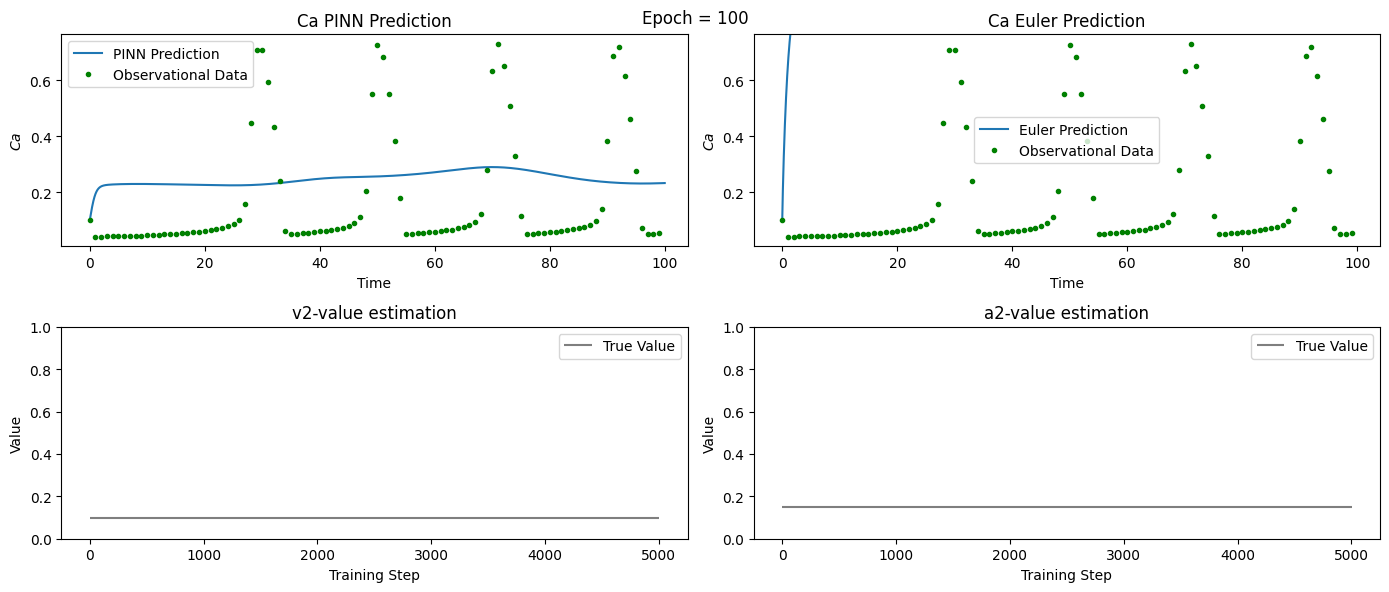

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(14, 6))

ax = axes[0, 0]
anim_plot1, = ax.plot([], [], label="PINN Prediction")
ax.plot(time, Ca_euler, '.g', label="Observational Data")
ax.set_title("Ca PINN Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("$Ca$")
ax.legend()

ax = axes[0, 1]
anim_plot2, = ax.plot([], [], label="Euler Prediction")
ax.plot(time, Ca_euler, '.g', label="Observational Data")
ax.set_title("Ca Euler Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("$Ca$")
ax.legend()

x_axis = np.linspace(0, epochs, 50)
ax = axes[1,0]
anim_plot3, = ax.plot([],[], c='green')
ax.hlines(v2_true, 0, epochs, color="tab:grey", label="True Value")
ax.set_title("v2-value estimation")
ax.set_xlabel("Training Step")
ax.set_ylabel("Value")
ax.set_ylim(0, 1)
ax.legend()

ax = axes[1,1]
anim_plot4, = ax.plot([],[], c='green')
ax.hlines(a2_true, 0, epochs, color="tab:grey", label="True Value")
ax.set_title("a2-value estimation")
ax.set_xlabel("Training Step")
ax.set_ylabel("Value")
ax.set_ylim(0, 1)
ax.legend()

def animate(i):
    plt.suptitle(f"Epoch = {100*(i+1)}")
    anim_plot1.set_data(t_test.squeeze(), Ca_predict[i])
    anim_plot2.set_data(t_test.squeeze(), Ca_euler_pred[i])
    anim_plot3.set_data(x_axis[:i], v2s[:i])
    anim_plot4.set_data(x_axis[:i], a2s[:i])
    return anim_plot1, anim_plot2, 

plt.tight_layout()

animation = FuncAnimation(fig, animate, frames=50, interval=10)
animation.save("Videos/PINN_100_error_low.gif")
# plt.show()


In [1]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

def lirinzel_ns(v2, a2, IP3, d5, k3, Ca0, dt):
    c0, c1 = 2, 0.185
    v1, v3 = 6, 0.9
    d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2
    time = np.arange(0, 338, dt)
    dt = dt
    Ca, h = [Ca0], [Ca0]  # Initialize lists

    # ODE solving
    for _ in range(1, len(time)):  # Start from index 1 to avoid index errors
        CaER = (c0 - Ca[-1]) / c1
        pinf = IP3 / (IP3 + d1)
        ninf = Ca[-1] / (Ca[-1] + d5)
        Q2 = d2 * (IP3 + d1) / (IP3 + d3)
        tauh = 1 / (a2 * (Q2 + Ca[-1]))
        hinf = Q2 / (Q2 + Ca[-1])
        alphah = hinf / tauh
        betah = (1 - hinf) / tauh
        dh = alphah * (1 - h[-1]) - betah * h[-1]
        dCa = (c1 * v1 * pinf**3 * ninf**3 * h[-1]**3 * (CaER - Ca[-1]) +
               c1 * v2 * (CaER - Ca[-1]) -
               v3 * Ca[-1]**2 / (Ca[-1]**2 + k3**2))

        # Append new values instead of assigning to an index
        Ca.append(Ca[-1] + dCa * dt)
        h.append(h[-1] + dh * dt)

    # Convert to NumPy array for interpolation
    Ca = np.array(Ca)
    h = np.array(h)

    return Ca, h

def normalisation(k_Ca):
    min_Ca = np.min(k_Ca)
    max_Ca = np.max(k_Ca)
    return (k_Ca - min_Ca) / (max_Ca - min_Ca)

In [2]:
df = pd.read_excel("Data/experimental.xlsx", header=None)
Ca_1 = df.iloc[:, 0]
Ca_2 = df.iloc[:, 1]

Ca_1 = np.array(Ca_1)
Ca_2 = np.array(Ca_2)

Ca_1_norm = normalisation(Ca_1)
Ca_2_norm = normalisation(Ca_2)

In [45]:
class FourierFeatureLayer(nn.Module):
    def __init__(self, num_features=1, std=1.0):
        super(FourierFeatureLayer, self).__init__()
        self.num_features = num_features
        self.std = std
        mean = 0.0
        size = (num_features, 1)
        self.sine_coeff = nn.Parameter(torch.normal(mean, std, size=size))   
        self.cosine_coeff = nn.Parameter(torch.normal(mean, std, size=size))

    def forward(self, t): 
        sine_feats = torch.sin(torch.matmul(t, self.sine_coeff.T))    
        cosine_feats = torch.cos(torch.matmul(t, self.cosine_coeff.T))
        feat = torch.cat([sine_feats, cosine_feats], dim=1)
        return feat

class PinnModel(nn.Module):
    def __init__(self, hidden_units, num_features, std, y0):
        super().__init__()
        self.y0 = y0
        self.feature = FourierFeatureLayer(num_features=num_features, std=std)
        self.layer1 = nn.Linear(in_features=2*num_features, out_features=hidden_units)
        self.tanh = nn.Tanh()
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer4 = nn.Linear(in_features=hidden_units, out_features=2)

    def forward(self, x):
        out = self.layer4(self.tanh(self.layer3(self.tanh(self.layer2(self.tanh(self.layer1(self.feature(x))))))))
        scaled = self.y0 + self.tanh(x) * torch.tensor([1, 1]) * out
        return scaled

In [46]:
torch.manual_seed(42)
y0 = torch.tensor([Ca_2_norm[0], Ca_2_norm[0]]).view(1,-1)
pinn = PinnModel(hidden_units=30, num_features=3, std=0.4, y0=y0)

Ca_exp = torch.tensor(Ca_2_norm, dtype=torch.float)
t_test = torch.arange(0, 338, 0.1).view(-1, 1)
time = torch.arange(0, 338, 1.0).view(-1, 1)
t_physics = torch.linspace(0, 338, 200, requires_grad=True).view(-1, 1)

c0, c1 = 2, 0.185
v1, v3 = 6, 0.9
d1, d2, d3, Nd = 0.13, 1.049, 0.9434, 2

v2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
a2 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
IP3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
d5 = torch.nn.Parameter(torch.rand(1, requires_grad=True))
k3 = torch.nn.Parameter(torch.rand(1, requires_grad=True))

lam1, lam2 = 1e-2, 1.5e-2
optimiser = torch.optim.Adam(list(pinn.parameters()) + [v2, a2, IP3, d5, k3], lr=0.0001)
epochs =  200001

Ca_predict = []
Ca_euler_pred = []

v2s = []
a2s = []
IP3s = []
d5s = []
k3s = []

for i in range(epochs):

    optimiser.zero_grad()

    pinn.train()

    # Data loss
    sol = pinn(time)
    Ca_preds = sol[:, 0].view(-1, 1)
    loss1 = torch.mean((Ca_preds.squeeze() - Ca_exp)**2)

    # Physics loss
    Ca = pinn(t_physics)[:, 0].view(-1, 1)
    dCa_dt = torch.autograd.grad(Ca, t_physics, torch.ones_like(Ca), create_graph=True, retain_graph=True)[0]

    h = pinn(t_physics)[:, 1].view(-1, 1)
    dh_dt = torch.autograd.grad(h, t_physics, torch.ones_like(h), create_graph=True, retain_graph=True)[0]

    pinf = IP3 / (IP3 + d1)
    Q2 = d2 * (IP3 + d1) / (IP3 + d3)
    CaER = (c0 - Ca) / c1
    ninf = Ca / (Ca + d5)
    tauh = 1 / (a2 * (Q2 + Ca))
    hinf = Q2 / (Q2 + Ca)
    alphah = hinf / tauh
    betah = (1 - hinf) / tauh

    res1 = dCa_dt - (c1*v1*(pinf**3)*(ninf**3)*(h**3)*(CaER - Ca) + c1*v2*(CaER-Ca) - v3*(Ca**2 / (Ca**2 + k3**2)))
    res2 = dh_dt - (alphah*(1-h) - betah*h)
    loss3 = torch.mean((res1)**2)
    loss4 = torch.mean((res2)**2)

    # Total loss
    loss = lam1*(loss1) + lam2*(loss3 + loss4)
    loss.backward()
    optimiser.step()

    if i % 2000 == 0:
        
        v2s.append(v2.item())
        a2s.append(a2.item())
        IP3s.append(IP3.item())
        d5s.append(d5.item())
        k3s.append(k3.item())

        if v2s[-1] == np.nan:
           break

        pinn.eval()
        with torch.inference_mode():
          Ca_pred, _ = [pinn(t_test)[:,i] for i in range(2)]

        Ca_predict.append(np.array(Ca_pred.detach().squeeze()))
        Ca_euler_pred.append(lirinzel_ns(v2s[-1], a2s[-1], IP3s[-1], d5s[-1], k3s[-1], Ca0=Ca_2_norm[0], dt=0.01)[0])


        print(f"Epoch = {i} | v2 = {v2s[-1]}")

Epoch = 0 | v2 = 0.7757574319839478
Epoch = 2000 | v2 = 0.685457706451416
Epoch = 4000 | v2 = 0.5336166620254517
Epoch = 6000 | v2 = 0.3868904113769531
Epoch = 8000 | v2 = 0.3098125755786896
Epoch = 10000 | v2 = 0.29662540555000305
Epoch = 12000 | v2 = 0.28551965951919556
Epoch = 14000 | v2 = 0.3161764442920685
Epoch = 16000 | v2 = 0.34389349818229675
Epoch = 18000 | v2 = 0.32964473962783813
Epoch = 20000 | v2 = 0.27429935336112976
Epoch = 22000 | v2 = 0.23338240385055542
Epoch = 24000 | v2 = 0.20362794399261475
Epoch = 26000 | v2 = 0.17991726100444794
Epoch = 28000 | v2 = 0.16012786328792572
Epoch = 30000 | v2 = 0.14282259345054626
Epoch = 32000 | v2 = 0.12757475674152374
Epoch = 34000 | v2 = 0.11362570524215698
Epoch = 36000 | v2 = 0.10094445198774338
Epoch = 38000 | v2 = 0.08930660784244537
Epoch = 40000 | v2 = 0.07841037213802338
Epoch = 42000 | v2 = 0.0681920200586319
Epoch = 44000 | v2 = 0.058649640530347824
Epoch = 46000 | v2 = 0.049645066261291504
Epoch = 48000 | v2 = 0.0411808

In [47]:
Ca_predict = np.array(Ca_predict)
Ca_euler_pred = np.array(Ca_euler_pred)

MovieWriter ffmpeg unavailable; using Pillow instead.


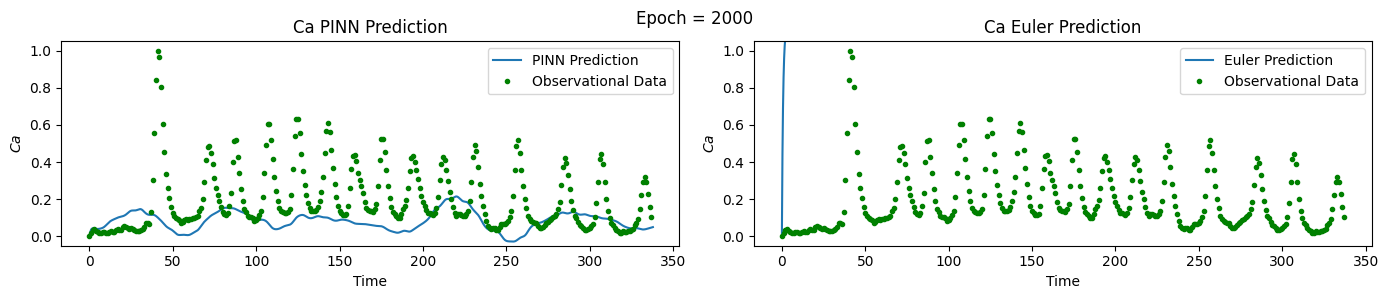

In [48]:

fig, axes = plt.subplots(1, 2, figsize=(14, 3))
time = np.arange(0, 338, 1.0)

ax = axes[0]
anim_plot1, = ax.plot([], [], label="PINN Prediction")
ax.plot(time, Ca_exp, '.g', label="Observational Data")
ax.set_title("Ca PINN Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("$Ca$")
ax.legend()

ax = axes[1]
anim_plot2, = ax.plot([], [], label="Euler Prediction")
ax.plot(time, Ca_exp, '.g', label="Observational Data")
ax.set_title("Ca Euler Prediction")
ax.set_xlabel("Time")
ax.set_ylabel("$Ca$")
ax.legend()

t_euler = np.arange(0, 338, 0.01)

def animate(i):
    plt.suptitle(f"Epoch = {2000*(i+1)}")
    anim_plot1.set_data(t_test.squeeze(), Ca_predict[i])
    anim_plot2.set_data(t_euler, Ca_euler_pred[i])
    return anim_plot1, anim_plot2, 

plt.tight_layout()

animation = FuncAnimation(fig, animate, frames=100, interval=10)
animation.save("Videos/PINN_exp_data1.gif")
# plt.show()


In [42]:
v2s[-1]

nan